In [1]:
%matplotlib inline
from helper import *
import plotter as pltr

In [2]:
# Hyper-parameters
window_size = 50
step_size = int(0.1 * window_size)
dataset = 'SMD'

## Step 1. Load Dataset

In [3]:
if dataset == 'SMD':
    GROUP = 1
    ENTITY = 2
    SMD_BASE_PATH = 'Dataset/SMD'

    X_train = load_data('%s/train/machine-%d-%d.txt' % (SMD_BASE_PATH, GROUP, ENTITY), header=False)
    X_train.columns = ['m%d' % i for i in range(X_train.shape[1])]
    X_train.index = pd.date_range('2021/03/02', '2021/03/21', periods=X_train.shape[0])
    X_train.index.name = 'timestamp'

    X_test = load_data('%s/test/machine-%d-%d.txt' % (SMD_BASE_PATH, GROUP, ENTITY), header=False)
    X_test.columns = ['m%d' % i for i in range(X_test.shape[1])]
    X_test.index = pd.date_range('2021/03/21', '2021/4/8', periods=X_test.shape[0])
    X_test.index.name = 'timestamp'

    y_true = pd.read_csv('Dataset/SMD/test_label/machine-%d-%d.txt' % (GROUP, ENTITY), header=None)
    y_true.columns = ['label']
    y_true.index = X_test.index

In [4]:
print('Train Shape:', X_train.shape)
print('Test Shape:', X_test.shape)

Train Shape: (23694, 37)
Test Shape: (23694, 37)


In [5]:
# plot the first dimension
pltr.plot_data(pd.concat([X_train, X_test], axis=0), 'm0')

In [6]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_true = y_true.to_numpy()
print("window size:", window_size)

window size: 50


## Step 2. Anomaly Detection

In [7]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import theano
import theano.tensor as tt

pm.set_tt_rng(42)
np.random.seed(42)

In [8]:
def w1(z):
    return tt.sin(2.0 * np.pi * z[0] / 4.0)


def w2(z):
    return 3.0 * tt.exp(-0.5 * ((z[0] - 1.0) / 0.6) ** 2)


def w3(z):
    return 3.0 * (1 + tt.exp(-(z[0] - 1.0) / 0.3)) ** -1


def pot1(z):
    z = z.T
    return 0.5 * ((z.norm(2, axis=0) - 2.0) / 0.4) ** 2 - tt.log(
        tt.exp(-0.5 * ((z[0] - 2.0) / 0.6) ** 2) + tt.exp(-0.5 * ((z[0] + 2.0) / 0.6) ** 2)
    )


def pot2(z):
    z = z.T
    return 0.5 * ((z[1] - w1(z)) / 0.4) ** 2 + 0.1 * tt.abs_(z[0])


def pot3(z):
    z = z.T
    return -tt.log(
        tt.exp(-0.5 * ((z[1] - w1(z)) / 0.35) ** 2)
        + tt.exp(-0.5 * ((z[1] - w1(z) + w2(z)) / 0.35) ** 2)
    ) + 0.1 * tt.abs_(z[0])


def pot4(z):
    z = z.T
    return -tt.log(
        tt.exp(-0.5 * ((z[1] - w1(z)) / 0.4) ** 2)
        + tt.exp(-0.5 * ((z[1] - w1(z) + w3(z)) / 0.35) ** 2)
    ) + 0.1 * tt.abs_(z[0])


z = tt.matrix("z")
z.tag.test_value = pm.floatX([[0.0, 0.0]])
pot1f = theano.function([z], pot1(z))
pot2f = theano.function([z], pot2(z))
pot3f = theano.function([z], pot3(z))
pot4f = theano.function([z], pot4(z))

In [9]:
def contour_pot(potf, ax=None, title=None, xlim=5, ylim=5):
    grid = pm.floatX(np.mgrid[-xlim:xlim:100j, -ylim:ylim:100j])
    grid_2d = grid.reshape(2, -1).T
    cmap = plt.get_cmap("inferno")
    if ax is None:
        _, ax = plt.subplots(figsize=(12, 9))
    pdf1e = np.exp(-potf(grid_2d))
    contour = ax.contourf(grid[0], grid[1], pdf1e.reshape(100, 100), cmap=cmap)
    if title is not None:
        ax.set_title(title, fontsize=16)
    return ax

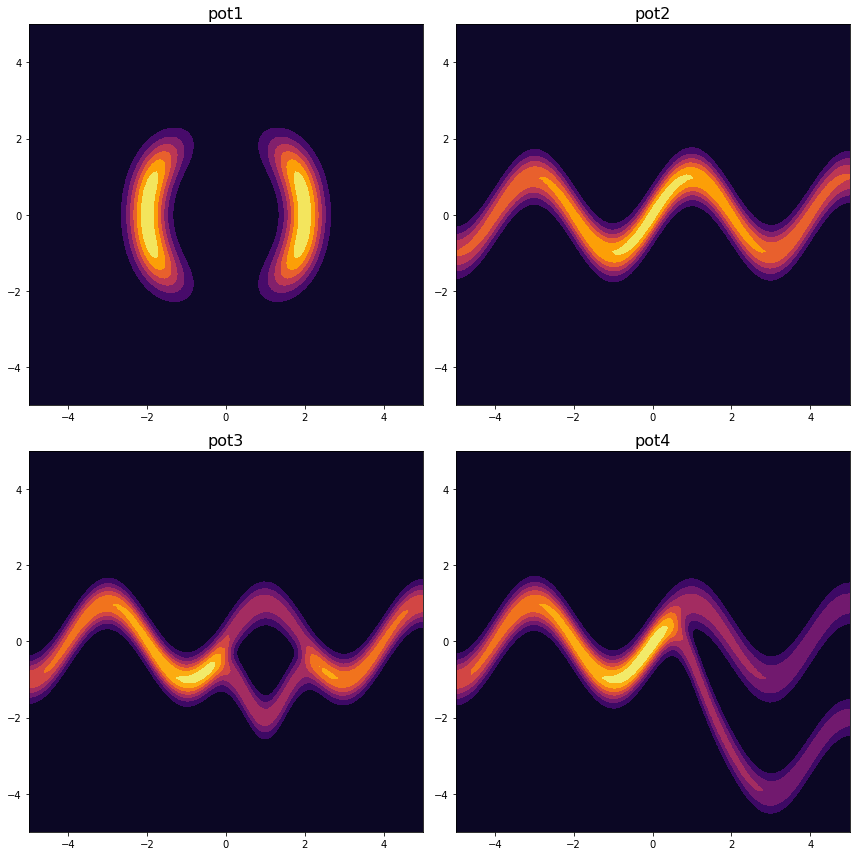

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.flatten()
contour_pot(
    pot1f,
    ax[0],
    "pot1",
)
contour_pot(pot2f, ax[1], "pot2")
contour_pot(pot3f, ax[2], "pot3")
contour_pot(pot4f, ax[3], "pot4")
fig.tight_layout()

In [15]:
from pymc3.distributions.dist_math import bound

def cust_logp(z):
    # return bound(-pot1(z), z>-5, z<5)
    return -pot1(z)


with pm.Model() as pot1m:
    pm.DensityDist("pot1", logp=cust_logp, shape=(X_train.shape[1],))
    # N = pm.Normal("pot1", mu=0., sigma=1., shape=(X_train.shape[1],), observed=X_train)

In [16]:
pm.set_tt_rng(42)
np.random.seed(42)

with pot1m:
    trace = pm.sample(
        1000,
        init="auto",
        cores=2,
        start=[dict(pot1=np.random.rand(X_train.shape[1])), dict(pot1=np.random.rand(X_train.shape[1]))],
    )

/tmp/ipykernel_4153462/3824575978.py:5: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [pot1]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
The number of effective samples is smaller than 25% for some parameters.


/home/ubuntu/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



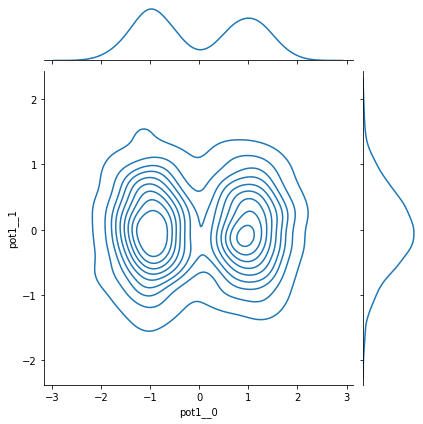

In [17]:
dftrace = pm.trace_to_dataframe(trace)
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind="kde")

In [18]:
with pot1m:
    inference = pm.NFVI("planar*10", jitter=0.1)

In [19]:
inference.fit(
    25000,
    obj_optimizer=pm.adam(learning_rate=0.01),
    obj_n_mc=100,
    callbacks=[pm.callbacks.CheckParametersConvergence()],
)

Finished [100%]: Average Loss = -5.5036


/home/ubuntu/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



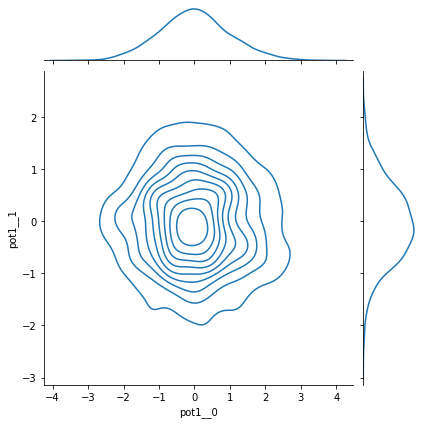

In [20]:
dftrace = pm.trace_to_dataframe(inference.approx.sample(1000))
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind="kde")